In [1]:
import matplotlib
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from classifier import ProCNN, Tensorize, Vocab
from data import PandasDataset
from interpretation_utilities import *

In [2]:
USE_CUDA = True

## Model Hyperparameters

In [3]:
CONFIG = {
   "learning_rate": 0.00010229218879330196,
   "weight_decay": 0.0016447149582678627,
   "xt_hidden": 1024,
   "seq_length": 1000,
   "conv1_ksize": 9,
   "conv1_knum": 256,
   "pool1": 19,
   "conv2_ksize": 13,
   "conv2_knum": 64,
   "pool2": 8,
   "batch_size": 256,
   "conv_activation" : "relu",
   "fc_activation" : "elu",
   "conv_dropout": 0.3981796388676127,
   "tf_dropout": 0.18859739941162465,
   "fc_dropout": 0.016570328292903613,
   "use_cuda": USE_CUDA,
   "prefix":'nc_elem_',
   "num_tfs":325
}

## Device Setup

In [4]:
if USE_CUDA:
    print("using gpu")
    cuda = torch.device('cuda')
    FloatTensor = torch.cuda.FloatTensor
    LongTensor = torch.cuda.LongTensor
    def cudaify(model):
        return model.cuda()
else: 
    print("using cpu")
    cuda = torch.device('cpu')
    FloatTensor = torch.FloatTensor
    LongTensor = torch.LongTensor
    def cudaify(model):
        return model

using gpu


## Load Data

In [7]:
dataset = PandasDataset('/home/simonl2/yeast/Gene_Expression_Pred/Dec_Jan_Runs/Data_pkl/file_oav_filt05_filtcv3_Zlog_new_allUniqueGenes.pkl')
loader = DataLoader(dataset, batch_size=64, num_workers=8, pin_memory=True, shuffle=False)

In [9]:
char_vocab = Vocab(['A', 'C', 'G', 'N', 'T'])    
tens = Tensorize(char_vocab, CONFIG["seq_length"], cudaify)
char_vocab.index_map
char_vocab_inv_map = {v: k for k, v in char_vocab.index_map.items()}

In [10]:
def extract_nucleotide_alphabet(dataset):
    symbols = set()
    all_symbols = []
    for sequence in dataset.select('seq'):
        letters = set(sequence)
        symbols = symbols | letters
        all_symbols += list(sequence)
        
    freqs = dict()
    for sym in symbols:
        freqs[sym] = sum([1 for i in all_symbols if i == sym]) / len(all_symbols)
        
    return sorted(list(symbols)), freqs

_, frequencies = extract_nucleotide_alphabet(dataset)

## Load Model

In [11]:
checkpoint_state = torch.load('/home/simonl2/yeast/Gene_Expression_Pred/Dec_Jan_Runs/nc_elem_best_net/checkpoint.pt')
model = ProCNN(CONFIG, 1, char_vocab)
model.load_state_dict(checkpoint_state["model_state_dict"])
model.eval()

ProCNN(
  (conv1): Conv1d(5, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (pool1): MaxPool1d(kernel_size=19, stride=19, padding=0, dilation=1, ceil_mode=False)
  (activation1): ReLU()
  (conv1dropout): Dropout(p=0.3981796388676127, inplace=False)
  (conv1bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(256, 64, kernel_size=(13,), stride=(1,), padding=(6,))
  (pool2): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (activation2): ReLU()
  (conv2dropout): Dropout(p=0.3981796388676127, inplace=False)
  (conv2bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_t): Linear(in_features=325, out_features=1024, bias=True)
  (fc_t_activation): ELU(alpha=1.0)
  (fc_t_dropout): Dropout(p=0.016570328292903613, inplace=False)
  (fc1): Linear(in_features=1408, out_features=512, bias=True)
  (fc1_activation): ELU(alpha=1.0)
  (fc1_dropout): Dropout(p=0.016570328292903613, i

In [12]:
cnn_conv = torch.nn.Sequential(*list(model.children())[:1]+[torch.nn.ReLU()])
cnn_conv = cudaify(cnn_conv)
cnn_conv

Sequential(
  (0): Conv1d(5, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (1): ReLU()
)

## Generate Feature Maps

In [13]:
cnn_conv.eval()
fmap = []
x_test = []
with torch.no_grad():
    for i, data in enumerate(loader):
        input_s, _, _ = tens(data)
        fmap.append(cnn_conv(input_s).to("cpu"))
        x_test.append(input_s.to("cpu"))
            
fmap = np.concatenate(fmap)
x_test = np.concatenate(x_test)

In [14]:
print(fmap.shape, x_test.shape)

(5681, 256, 1000) (5681, 5, 1000)


In [15]:
torch.save(fmap, f"nc-elem-promoters-fmap.pt", pickle_protocol=4)

## Generate PWMs

In [16]:
window = 9
c = 1
percentile_cutoff = 99.5
top_k = fmap.shape[0] * 5 # Top 0.5% of each filter

promoter_pwms, promoter_entropies = get_pwms(x_test, fmap, window, c, top_k)

In [17]:
torch.save(promoter_pwms, f"nc-elem-promoters-window{window}-top{top_k}-pwms.pt")

In [18]:
prefix = f"nc-elem-promoters-window{window}-top{top_k}"

meme_string = get_MEME_string(promoter_pwms, frequencies, window)
with open(f"{prefix}-filter_pwm.txt", "w") as f:
    f.write(meme_string)

## Generate Motif Figures

KeyboardInterrupt: 

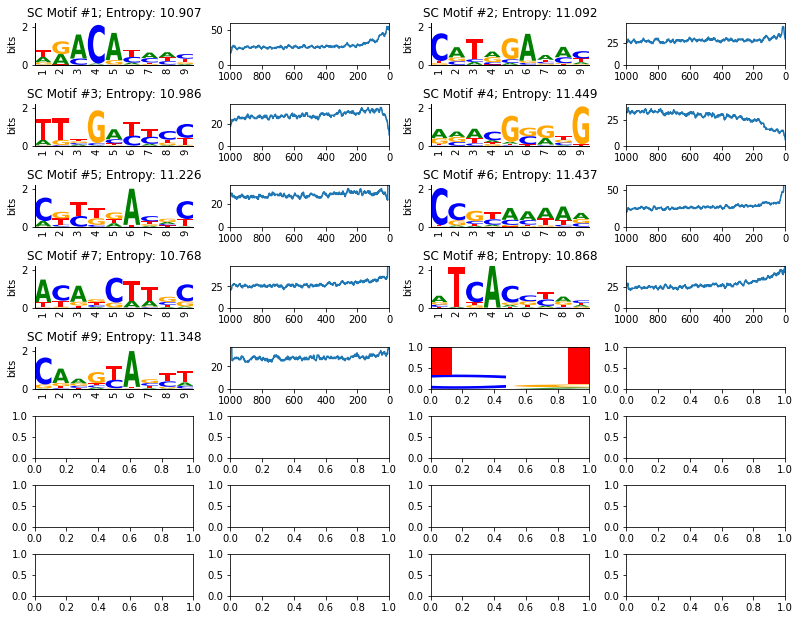

In [19]:
NUM_PER_PAGE = 16

from matplotlib.backends.backend_pdf import PdfPages

with PdfPages(f"nc-elem-promoters-window{window}-smoothed-top{top_k}.pdf") as pdf:
    for page in range((len(promoter_pwms) + NUM_PER_PAGE - 1) // NUM_PER_PAGE):
        start = page * NUM_PER_PAGE
        end = min((page + 1) * NUM_PER_PAGE, len(promoter_pwms))
        
        filter_plots = plot_promoter_filters(
            promoter_pwms, 
            fmap, 
            percentile_cutoff,
            [*range(start, end)], 
            [promoter_entropies[i] for i in range(start, end)]
        )
        pdf.savefig(filter_plots)

## Motif Table

In [20]:
motifs_df = pd.DataFrame(
    {
        "motif_id": [i + 1 for i in range(len(promoter_pwms))],
        f"activation_{percentile_cutoff}" : [activation_cutoff(fmap, i, percentile_cutoff) for i in range(len(promoter_pwms))],
        "entropy": promoter_entropies,
        "uniform_chisquare": [get_chisquare_uniform(fmap, i, percentile_cutoff) for i in range(len(promoter_pwms))],
        "consensus_sequence": [get_consensus_sequence(promoter_pwms[i], char_vocab_inv_map) for i in range(len(promoter_pwms))],
        "top1pct_sequences": [get_top_sequences(fmap, i, dataset, 99) for i in range(len(promoter_pwms))]
    }
)

In [21]:
motifs_df.to_csv(f"nc-elem-promoters-window{window}-top{top_k}-motifs.tsv", sep="\t", index=False)